In [1]:
from unet_model1 import UNet as UNetModel1
from unet_model2 import UNet as UNetModel2


In [2]:
# ---------------- STEP 1: Configuration Setup ----------------

import os
import random
import numpy as np
import torch

# Path to the preprocessed dataset
DATA_DIR = "/Users/aman/Python/BRAIN MRI U-Net/processed_data"

# Image size to which all slices will be resized
IMAGE_SIZE = (128, 128)

# Seed value for reproducibility
SEED = 42

# Set seed for torch, numpy, and random
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Apply the seed
set_seed(SEED)

In [3]:
# ---------------- STEP 2: Dataset Class (MRIDataset) - FIXED ----------------

from torch.utils.data import Dataset
import numpy as np
import torch
import os

class MRIDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, balance_foreground=False):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.balance_foreground = balance_foreground

        self.images_dir = os.path.join(root_dir, split, "images")
        self.masks_dir = os.path.join(root_dir, split, "masks")

        # List all valid image-mask pairs
        self.image_files = []
        for fname in sorted(os.listdir(self.images_dir)):
            if fname.endswith(".npy"):
                mask_name = fname.replace(".npy", "_mask.npy")
                if os.path.exists(os.path.join(self.masks_dir, mask_name)):
                    self.image_files.append(fname)

        # Optionally filter images with non-zero masks (foreground balancing)
        if self.balance_foreground and split == "train":
            filtered = []
            for f in self.image_files:
                mask_path = os.path.join(self.masks_dir, f.replace(".npy", "_mask.npy"))
                mask = np.load(mask_path)
                if (mask > 0).sum() > 10:
                    filtered.append(f)
            if len(filtered) > 0:
                self.image_files = filtered

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = img_name.replace(".npy", "_mask.npy")

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.uint8)

        # Normalize image to [0, 1]
        if image.max() > image.min():
            image = (image - image.min()) / (image.max() - image.min())
        else:
            image = np.zeros_like(image)

        # Binarize mask
        mask = (mask > 0).astype(np.uint8)

        # Convert shape to HWC for albumentations
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Apply transforms if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  # Tensor: [1, H, W]
            mask = augmented["mask"]    # Tensor: [H, W, 1] or [1, H, W]
            
            # FIXED: Ensure mask has the same shape as image [1, H, W]
            if isinstance(mask, torch.Tensor):
                if mask.ndim == 3 and mask.shape[0] != 1:
                    # If mask is [H, W, 1], convert to [1, H, W]
                    mask = mask.permute(2, 0, 1)
                elif mask.ndim == 2:
                    # If mask is [H, W], add channel dimension
                    mask = mask.unsqueeze(0)
            else:
                # If mask is numpy array, convert to tensor with correct shape
                mask = torch.from_numpy(mask)
                if mask.ndim == 3 and mask.shape[0] != 1:
                    mask = mask.permute(2, 0, 1)
                elif mask.ndim == 2:
                    mask = mask.unsqueeze(0)
            
            mask = mask.float()
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).permute(2, 0, 1).float()

        return image, mask



In [4]:
# ---------------- STEP 3: Data Augmentation (Albumentations) ----------------

import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(split):
    if split == "train":
        return A.Compose([
            A.Resize(*IMAGE_SIZE),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Affine(scale=(0.9, 1.1), rotate=(-15, 15), shear=(-10, 10), translate_percent=(0, 0.05), p=0.5),
            A.ElasticTransform(alpha=1, sigma=50, p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(p=0.1),
            A.CoarseDropout(p=0.2),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(*IMAGE_SIZE),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>
  data = fetch_version_info()


In [5]:
# ---------------- STEP 4: DataLoader Setup ----------------

from torch.utils.data import DataLoader

def get_dataloaders(data_dir, batch_size=16, num_workers=2, balance_foreground=True):
    train_transform = get_transforms("train")
    val_transform = get_transforms("val")
    test_transform = get_transforms("test")

    train_dataset = MRIDataset(
        root_dir=data_dir,
        split="train",
        transform=train_transform,
        balance_foreground=balance_foreground
    )

    val_dataset = MRIDataset(
        root_dir=data_dir,
        split="val",
        transform=val_transform,
        balance_foreground=False
    )

    test_dataset = MRIDataset(
        root_dir=data_dir,
        split="test",
        transform=test_transform,
        balance_foreground=False
    )

    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader


In [6]:
# ---------------- STEP 5: Test the Fix ----------------

if __name__ == "__main__":
    print("Testing the fixed dataset...")
    
    # Load dataloaders
    train_loader, val_loader, test_loader = get_dataloaders(
        data_dir=DATA_DIR,
        batch_size=4,
        num_workers=0,
        balance_foreground=True
    )

    # Test a batch
    for images, masks in train_loader:
        print(f"✅ SUCCESS! Images shape: {images.shape}, Masks shape: {masks.shape}")
        print(f"✅ Shapes match: {images.shape == masks.shape}")
        break 
    

Testing the fixed dataset...
✅ SUCCESS! Images shape: torch.Size([4, 1, 128, 128]), Masks shape: torch.Size([4, 1, 128, 128])
✅ Shapes match: True


In [7]:
# ---------------- STEP 5: Loss Functions ----------------

import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Ensure preds are probabilities [0,1]
        preds = torch.sigmoid(preds)

        
        # Ensure targets are binary [0,1]
        targets = (targets > 0).float()
        
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth)
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        dice_loss = self.dice(preds, targets)  # Remove torch.sigmoid here
        return bce_loss + dice_loss


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Initialize models
model1 = UNetModel1(in_channels=1, out_channels=1, use_mc_dropout=True).to(device)
model2 = UNetModel2(in_channels=1, out_channels=1, use_mc_dropout=True).to(device)


In [18]:
# Loss function
criterion = BCEDiceLoss()

# Optimizers
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

# Learning rate schedulers
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=3)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=3)

# Mixed precision scaler 
scaler = torch.cuda.amp.GradScaler()

/var/folders/d5/x3yw4z3j7fv10bn3z7bhs_s00000gn/T/ipykernel_15753/3426969628.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [12]:
early_stopping_patience = 5
best_val_loss_1 = float('inf')
best_val_loss_2 = float('inf')
early_stopping_counter_1 = 0
early_stopping_counter_2 = 0

NUM_EPOCHS = 30


In [15]:
def train_one_epoch(model, dataloader, optimizer, criterion, scaler, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            outputs = model(images)
            loss = criterion(outputs, masks)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [16]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            # Dice Score Calculation
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            masks_bin = (masks > 0.5).float()

            intersection = (preds * masks_bin).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks_bin.sum(dim=(2, 3))
            dice = ((2. * intersection + 1e-6) / (union + 1e-6)).mean()

            dice_scores.append(dice.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = sum(dice_scores) / len(dice_scores)

    return epoch_loss, epoch_dice


In [19]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss_1 = train_one_epoch(model1, train_loader, optimizer1, criterion, scaler, device)
    val_loss_1, val_dice_1 = validate(model1, val_loader, criterion, device)
    scheduler1.step(val_loss_1)

    print(f"Model1 - Train Loss: {train_loss_1:.4f} | Val Loss: {val_loss_1:.4f} | Val Dice: {val_dice_1:.4f}")

    if val_loss_1 < best_val_loss_1:
        best_val_loss_1 = val_loss_1
        early_stopping_counter_1 = 0
        torch.save(model1.state_dict(), "checkpoints/best_model1.pth")
        print("Model1 saved!")
    else:
        early_stopping_counter_1 += 1
        if early_stopping_counter_1 >= early_stopping_patience:
            print("Early stopping triggered for Model1.")
            break



Epoch 1/30


/var/folders/d5/x3yw4z3j7fv10bn3z7bhs_s00000gn/T/ipykernel_15753/3297009038.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Model1 - Train Loss: 1.0329 | Val Loss: 1.0531 | Val Dice: 0.6232
Model1 saved!

Epoch 2/30
Model1 - Train Loss: 0.8965 | Val Loss: 1.0727 | Val Dice: 0.6232

Epoch 3/30
Model1 - Train Loss: 0.8712 | Val Loss: 1.0263 | Val Dice: 0.3460
Model1 saved!

Epoch 4/30
Model1 - Train Loss: 0.8121 | Val Loss: 0.9828 | Val Dice: 0.2183
Model1 saved!

Epoch 5/30
Model1 - Train Loss: 0.7681 | Val Loss: 1.0475 | Val Dice: 0.1040

Epoch 6/30
Model1 - Train Loss: 0.7568 | Val Loss: 3.0172 | Val Dice: 0.0305

Epoch 7/30
Model1 - Train Loss: 0.7259 | Val Loss: 1.0506 | Val Dice: 0.6232

Epoch 8/30
Model1 - Train Loss: 0.7140 | Val Loss: 1.0434 | Val Dice: 0.6232

Epoch 9/30
Model1 - Train Loss: 0.6902 | Val Loss: 0.9349 | Val Dice: 0.1903
Model1 saved!

Epoch 10/30
Model1 - Train Loss: 0.6747 | Val Loss: 0.9366 | Val Dice: 0.2094

Epoch 11/30
Model1 - Train Loss: 0.6608 | Val Loss: 0.9188 | Val Dice: 0.1988
Model1 saved!

Epoch 12/30
Model1 - Train Loss: 0.6593 | Val Loss: 0.9224 | Val Dice: 0.1925

Ep

In [20]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss_2 = train_one_epoch(model2, train_loader, optimizer2, criterion, scaler, device)
    val_loss_2, val_dice_2 = validate(model2, val_loader, criterion, device)
    scheduler2.step(val_loss_2)

    print(f"Model2 - Train Loss: {train_loss_2:.4f} | Val Loss: {val_loss_2:.4f} | Val Dice: {val_dice_2:.4f}")

    if val_loss_2 < best_val_loss_2:
        best_val_loss_2 = val_loss_2
        early_stopping_counter_2 = 0
        torch.save(model2.state_dict(), "checkpoints/best_model2.pth")
        print("Model2 saved!")
    else:
        early_stopping_counter_2 += 1
        if early_stopping_counter_2 >= early_stopping_patience:
            print("Early stopping triggered for Model2.")
            break



Epoch 1/30


/var/folders/d5/x3yw4z3j7fv10bn3z7bhs_s00000gn/T/ipykernel_15753/3297009038.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Model2 - Train Loss: 0.9675 | Val Loss: 1.0687 | Val Dice: 0.6232
Model2 saved!

Epoch 2/30
Model2 - Train Loss: 0.8052 | Val Loss: 1.0904 | Val Dice: 0.6232

Epoch 3/30
Model2 - Train Loss: 0.7514 | Val Loss: 1.0671 | Val Dice: 0.6232
Model2 saved!

Epoch 4/30
Model2 - Train Loss: 0.7319 | Val Loss: 1.0804 | Val Dice: 0.1527

Epoch 5/30
Model2 - Train Loss: 0.7232 | Val Loss: 1.0546 | Val Dice: 0.5648
Model2 saved!

Epoch 6/30
Model2 - Train Loss: 0.7103 | Val Loss: 0.9725 | Val Dice: 0.3064
Model2 saved!

Epoch 7/30
Model2 - Train Loss: 0.7055 | Val Loss: 0.9565 | Val Dice: 0.2248
Model2 saved!

Epoch 8/30
Model2 - Train Loss: 0.6812 | Val Loss: 1.0374 | Val Dice: 0.6232

Epoch 9/30
Model2 - Train Loss: 0.6813 | Val Loss: 1.0090 | Val Dice: 0.1983

Epoch 10/30
Model2 - Train Loss: 0.6715 | Val Loss: 0.9053 | Val Dice: 0.1977
Model2 saved!

Epoch 11/30
Model2 - Train Loss: 0.6372 | Val Loss: 1.0716 | Val Dice: 0.2346

Epoch 12/30
Model2 - Train Loss: 0.6093 | Val Loss: 1.0356 | Val Di

In [21]:
model1.load_state_dict(torch.load("checkpoints/best_model1.pth"))
model2.load_state_dict(torch.load("checkpoints/best_model2.pth"))
model1.eval()
model2.eval()


UNet(
  (enc1): DoubleConv(
    (mc_dropout): SafeIdentity()
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (mc_dropout): MCDropout()
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [22]:
test_loss_1, test_dice_1 = validate(model1, test_loader, criterion, device)
test_loss_2, test_dice_2 = validate(model2, test_loader, criterion, device)

print(f"Model1 - Test Loss: {test_loss_1:.4f}, Dice: {test_dice_1:.4f}")
print(f"Model2 - Test Loss: {test_loss_2:.4f}, Dice: {test_dice_2:.4f}")


Model1 - Test Loss: 0.8707, Dice: 0.2361
Model2 - Test Loss: 0.8562, Dice: 0.3189


In [26]:
def visualize_prediction(model, dataset, index, device):
    import matplotlib.pyplot as plt
    model.eval()
    image, mask = dataset[index]
    image = image.to(device).unsqueeze(0)  # Add batch dim

    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
    
    image = image.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred > 0.5, cmap="gray")
    plt.show()


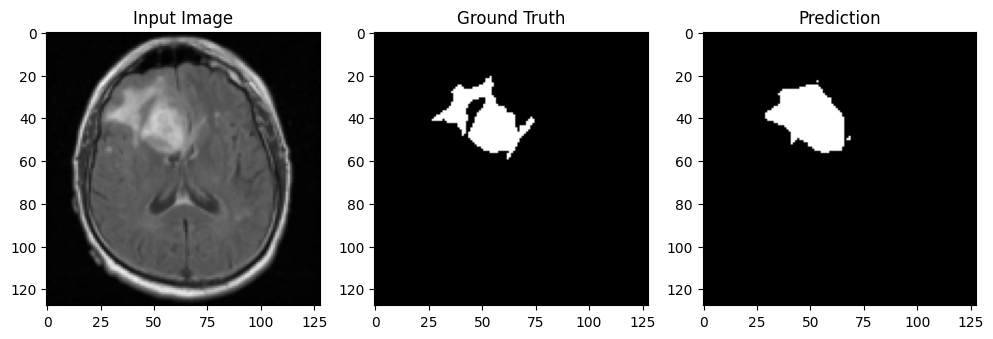

In [27]:
visualize_prediction(model1, test_loader.dataset, index=5, device=device)


In [28]:
def ensemble_predict(model1, model2, image, device):
    model1.eval()
    model2.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        out1 = torch.sigmoid(model1(image))
        out2 = torch.sigmoid(model2(image))
        avg_pred = (out1 + out2) / 2

    return avg_pred.squeeze().cpu().numpy()


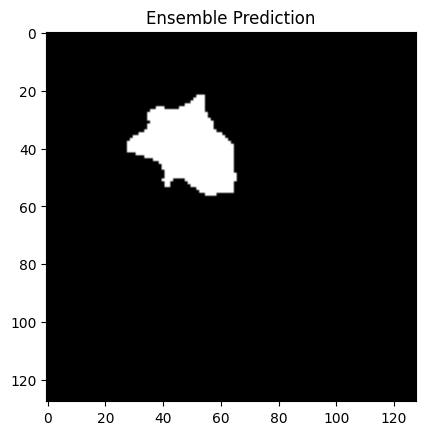

In [29]:
image, mask = test_loader.dataset[5]
pred = ensemble_predict(model1, model2, image, device)

plt.imshow(pred > 0.5, cmap="gray")
plt.title("Ensemble Prediction")
plt.show()


In [30]:
torch.save(model1, "final_model1.pth")
torch.save(model2, "final_model2.pth")


In [37]:
# -----------------------------
# Saving the Trained Model 1
# -----------------------------

import os  # Import OS module to handle file/directory operations

# Define the directory path where the model will be saved
save_dir = "saved_models/model1"

# Create the directory if it doesn't exist already
os.makedirs(save_dir, exist_ok=True)

# Save the TorchScript traced model (assuming you've already created it as 'traced')
traced.save(os.path.join(save_dir, "model1_traced.pt"))

# Optionally, save the raw PyTorch model weights too
torch.save(model1.state_dict(), os.path.join(save_dir, "model1_weights.pth"))

# Print confirmation
print(f"Model1 saved successfully in '{save_dir}'")


Model1 saved successfully in 'saved_models/model1'


In [38]:
# -----------------------------
# Loading a Saved Model 1
# -----------------------------

# Import the U-Net model class from your model definition file
from unet_model1 import UNet

# Instantiate the model architecture (make sure the parameters match the original training config)
model1 = UNet(in_channels=1, out_channels=1, use_mc_dropout=True)

# Load the saved model weights from the checkpoint file
# This loads only the learned parameters (not the entire model object)
model1.load_state_dict(torch.load("checkpoints/best_model1.pth"))

# Set the model to evaluation mode (important for dropout, batchnorm etc.)
model1.eval()



UNet(
  (enc1): DoubleConv(
    (dropout_layer): IdentityWithMC()
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (dropout_layer): MCDropout()
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum

In [39]:
# -----------------------------
# Creating Dummy Input for Tracing or Inference
# -----------------------------

# Create a dummy input tensor with the shape [batch_size, channels, height, width]
# Here, it's a batch of 1 image with 1 channel (grayscale), and resolution 256x256
dummy_input = torch.randn(1, 1, 256, 256).to(device)

# This is useful for:
# 1. Tracing the model using TorchScript (for saving/loading later)
# 2. Verifying the model's input/output shapes


In [41]:
# -----------------------------
# Saving the Trained Model 2
# -----------------------------

import os  # To create directories and handle file paths

# 1. Define the directory path where Model 2 will be saved
save_dir2 = "saved_models/model2"

# 2. Create the directory if it doesn't exist
os.makedirs(save_dir2, exist_ok=True)

# 3. Create a dummy input tensor that matches the expected input size of the model
# Format: (batch_size, channels, height, width) — adjust if different
dummy_input2 = torch.randn(1, 1, 256, 256).to(device)

# 4. Trace Model 2 using TorchScript (for deployment or future use without source code)
traced2 = torch.jit.trace(model2.to(device), dummy_input2)

# 5. Save the traced TorchScript model
traced2.save(os.path.join(save_dir2, "model2_traced.pt"))

# 6. Optionally, save just the raw model weights (PyTorch format)
torch.save(model2.state_dict(), os.path.join(save_dir2, "model2_weights.pth"))

# 7. Print confirmation message
print(f"Model2 saved successfully in '{save_dir2}'")


Model2 saved successfully in 'saved_models/model2'
